In [81]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
    
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
from natsort import natsorted

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
# import nlp_utils as nlp
from tommy_utils import nlp
from preproc_utils import load_model_results, divide_nwp_dataframe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'get_model_word_quadrants' from 'preproc_utils' (/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py)

In [139]:
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'final-multimodal-01'
TASK = 'odetostepfather'
# TASK = 'black'

gentle_dir = os.path.join(BASE_DIR, 'stimuli/gentle')
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')

# set the directories we need
models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')

word_model_name = 'fasttext'

## Load data for plotting

In [140]:
# something here
human_results_fn = os.path.join(results_dir, f'task-{TASK}_group-analyzed-behavior_human-lemmatized.csv')
df_human_results = pd.read_csv(human_results_fn)

# separate into dataf rames for comparison
df_audio, df_text = [df for i, df in df_human_results.groupby('modality')]

## Functions

In [7]:
def linear_norm(x, min, max):
    return (x - min) / (max - min)

def log_odds(x):
    return np.log((x/ (1-x)))

def plot_comparison_identity(ds_a, ds_b, lim):
    # plt.switch_backend('agg')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

    ax.plot(lim, lim, 'k--')
    ax.scatter(ds_a, ds_b, s=10, linewidth=0, alpha=0.3)
    ax.set_xlim(lim)
    ax.set_ylim(lim)

    return fig

def create_spoken_written_cmap(continuous=True):

    if continuous:
        spoken_written_cmap = clr.LinearSegmentedColormap.from_list('spoken-written', ['#005208', '#72D16B', '#808080', '#E4B266', '#623800'], N=256)
        spoken_written_cmap = spoken_written_cmap.reversed()
    else:
        spoken_written_cmap = sns.color_palette('BuPu', n_colors=9)
        spoken_written_cmap.insert(0, '#82C564')
        spoken_written_cmap.insert(1, '#F7CD84')
    return spoken_written_cmap

def get_ordered_accuracy(df_human_models, word_model_name='fasttext'):
    
    # Get order of models by binary accuracy
    ordered_accuracy = df_human_models.loc[:,['modality', f'{word_model_name}_avg_accuracy']] \
        .groupby(['modality']) \
        .mean() \
        .sort_values(by=f'{word_model_name}_avg_accuracy').index[::-1]

    return ordered_accuracy

## Plot human results - spoken vs. written language

### Plot 01 - Binary accuracy (spoken vs. written)

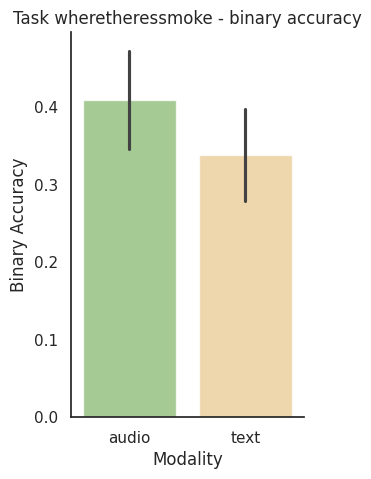

In [21]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = 'accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='modality', y=variable, hue='modality', palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=df_human_results, x='modality', y='binary_accuracy',  hue='modality', palette=cmap, size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Binary Accuracy')
plt.title(f'Task {TASK} - binary accuracy')
# plt.ylim(0, 0.4)

sns.despine()

### Plot 02 - Continuous accuracy (spoken vs. written)

TtestResult(statistic=1.1676318415699976, pvalue=0.2440167986987555, df=262)

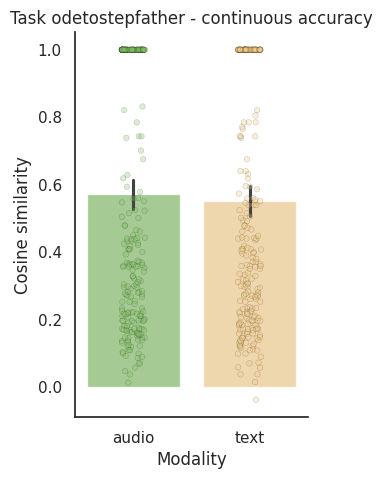

In [32]:
## sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = f'{word_model_name}_top_word_accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='modality', y=variable, hue='modality', palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_human_results, x='modality', y=variable,  hue='modality', palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Task {TASK} - continuous accuracy')
# plt.ylim(0, 0.4)

sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

### Plot 03 - Variability of human response probabilities 

TtestResult(statistic=1.5860583175227834, pvalue=0.11393223730549379, df=262)

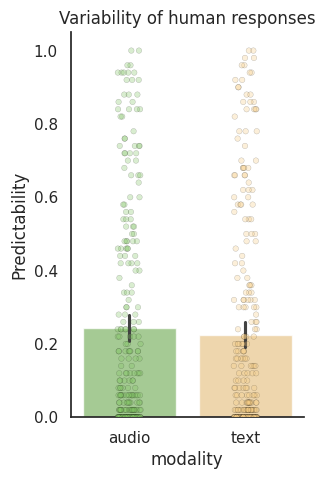

In [141]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = f'predictability'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='modality', y=variable, palette=cmap, alpha=0.75)
ax = sns.stripplot(data=df_human_results, x='modality', y=variable, palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)

plt.ylabel(variable.capitalize())
plt.title('Variability of human responses')
sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

# plt.savefig("human_response_variability.pdf", bbox_inches='tight', dpi=300)

### Plot 04 - Predictability

TtestResult(statistic=7.9805799296102125, pvalue=5.995038368365281e-14, df=240)

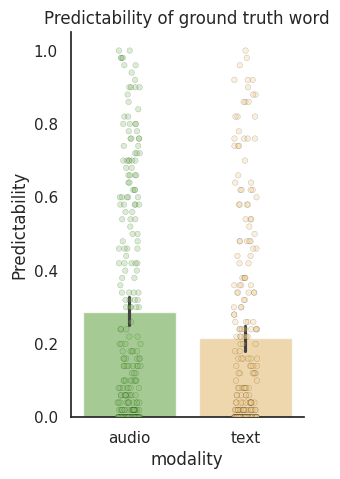

In [99]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = 'predictability'

ax = sns.barplot(data=df_human_results, x='modality', y=variable, palette=cmap, alpha=0.75)

ax = sns.stripplot(data=df_human_results, x='modality', y=variable, palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)

plt.ylabel('Predictability')
plt.title('Predictability of ground truth word')
sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

# plt.savefig("human_continuous_accuracy.pdf", bbox_inches='tight', dpi=300)

### Plot 05 - Predictability of ground truth word

In [45]:
df_predictability = pd.pivot(df_human_results, index='word_index', columns='modality', values='predictability')
df_modality_accuracy = pd.pivot(df_human_results, index='word_index', columns='modality', values=f'fasttext_top_word_accuracy')

colors = df_predictability['audio'] - df_predictability['text']
colors = linear_norm(colors.to_numpy(), -1, 1)

df_predictability['colors'] = colors

0.7399480412864091 1.106948569602222e-56


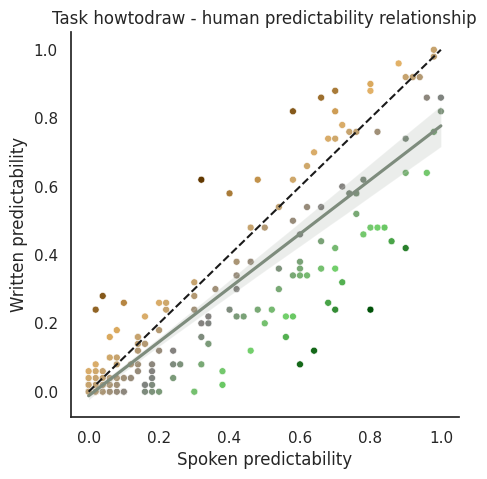

In [46]:
cmap = create_spoken_written_cmap()
sns.set(style='white', rc={'figure.figsize':(5,5)})

ax = sns.scatterplot(data=df_predictability, x='audio', y='text', hue='colors', palette=cmap, alpha=1, s=25) #, ax=ax)
ax = sns.regplot(data=df_predictability, x='audio', y='text', color=cmap(df_predictability['colors'].mean()), scatter=False, ax=ax) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)

plt.plot((0,1), (0, 1), 'k--')
r, pval = kendalltau(df_predictability['audio'], df_predictability['text'])
print (r, pval)

ax.get_legend().remove()

# plt.ylim(0, 1)
# plt.xlim(0, 1)

plt.ylabel('Written predictability')
plt.xlabel('Spoken predictability') 

plt.title(f'Task {TASK} - human predictability relationship')
sns.despine()
# plt.savefig("human_predictability.pdf", bbox_inches='tight', dpi=300)

## Plot human vs. LLM results

### Load data for plotting

In [120]:
# something here
compiled_results_fn = os.path.join(results_dir, f'task-{TASK}_group-analyzed-behavior_human-model-lemmatized.csv')
df_human_models = pd.read_csv(compiled_results_fn)

# make a new dataframe and drop missing values --> this is specifically for stats
df_anova = df_human_models.copy()
df_anova = df_anova[~df_anova[f'{word_model_name}_avg_accuracy'].isna()]

### Set model names and display order

In [70]:
# get all MLM models except BERT
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]
CLM_MODELS = list(nlp.CLM_MODELS_DICT.keys()) 
model_names = CLM_MODELS + MLM_MODELS

print (f'Loading the following models')
print (f'MLM models: {MLM_MODELS}')
print (f'CLM models: {CLM_MODELS}')

ordered_accuracy = get_ordered_accuracy(df_human_models)

# now order the models and conditions for plotting
human_conditions = ['audio', 'text']
ordered_models = [item for item in ordered_accuracy if item not in ['audio', 'text', *MLM_MODELS]]
ordered_modalities = human_conditions + ordered_models + MLM_MODELS
ordered_conditions = ['low-high', 'high-high', 'low-low', 'high-low']

Loading the following models
MLM models: ['roberta', 'electra', 'xlm-prophetnet']
CLM models: ['bloom', 'gpt2', 'gpt2-xl', 'gpt-neo-x', 'llama2', 'mistral']


### Plot 01 - Binary accuracy

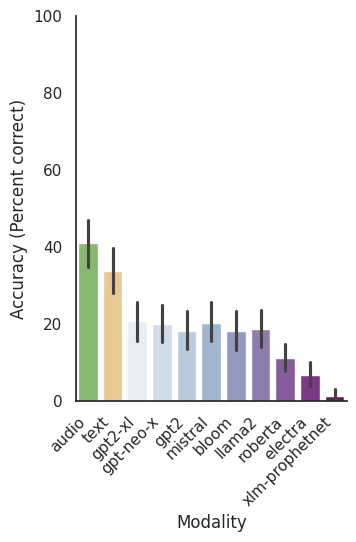

In [58]:
cmap = create_spoken_written_cmap(continuous=False)
sns.set(style='white', rc={'figure.figsize':(3.5,5), "axes.titlesize":18}, font_scale=1)

variable = 'accuracy'

ax = sns.barplot(data=df_human_models, x='modality', y=variable, palette=cmap, order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=human_model_combined, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Accuracy (Percent correct)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

sns.despine()
# plt.savefig("binary_accuracy.pdf", bbox_inches='tight', dpi=600)

### Plot 02 - Continuous accuracy

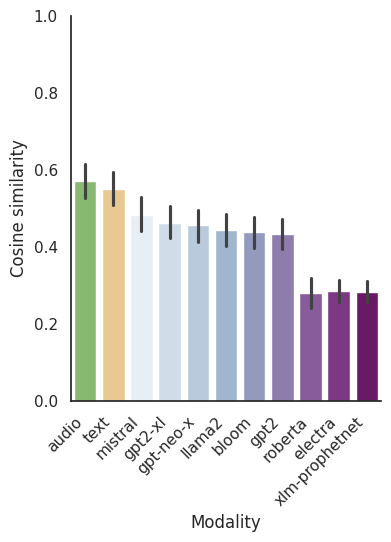

In [71]:
cmap = create_spoken_written_cmap(continuous=False)
sns.set(style='white', rc={'figure.figsize':(4,5), "axes.titlesize":18}, font_scale=1)

variable = 'fasttext_avg_accuracy'

ax = sns.barplot(data=df_human_models, x='modality', y=variable, palette=cmap, order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=human_model_combined, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

sns.despine()
# plt.savefig("binary_accuracy.pdf", bbox_inches='tight', dpi=600)

#### Statistics

In [73]:
variable = f'{word_model_name}_avg_accuracy'

model = ols(f'{variable} ~ modality', data=df_anova).fit() #df_anova.dropna()).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print (anova_table)

# human_model_combined = human_model_combined.dropna()

hs_res=pairwise_tukeyhsd(df_anova[variable], df_anova['modality'])
print(hs_res)

               sum_sq      df           F         PR(>F)
Intercept   85.762300     1.0  822.791337  4.204355e-159
modality    26.815613    10.0   25.726518   2.811342e-47
Residual   295.605789  2836.0         NaN            NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
    audio          bloom  -0.1331 0.0001 -0.2237 -0.0424   True
    audio        electra   -0.287    0.0 -0.3777 -0.1963   True
    audio      gpt-neo-x  -0.1158  0.002 -0.2067  -0.025   True
    audio           gpt2  -0.1387    0.0 -0.2294  -0.048   True
    audio        gpt2-xl  -0.1084 0.0058 -0.1992 -0.0176   True
    audio         llama2  -0.1281 0.0003 -0.2191  -0.037   True
    audio        mistral  -0.0884 0.0663 -0.1794  0.0027  False
    audio        roberta  -0.2918    0.0 -0.3851 -0.1986   True
    audio           text  -0.0203 0.9997  -0.111  0.0704  False
    

### Plot 03 - Continuous accuracy x entropy/accuracy group 

Also contains ANOVA + pairwise tests within each entropy/accuracy quadrant

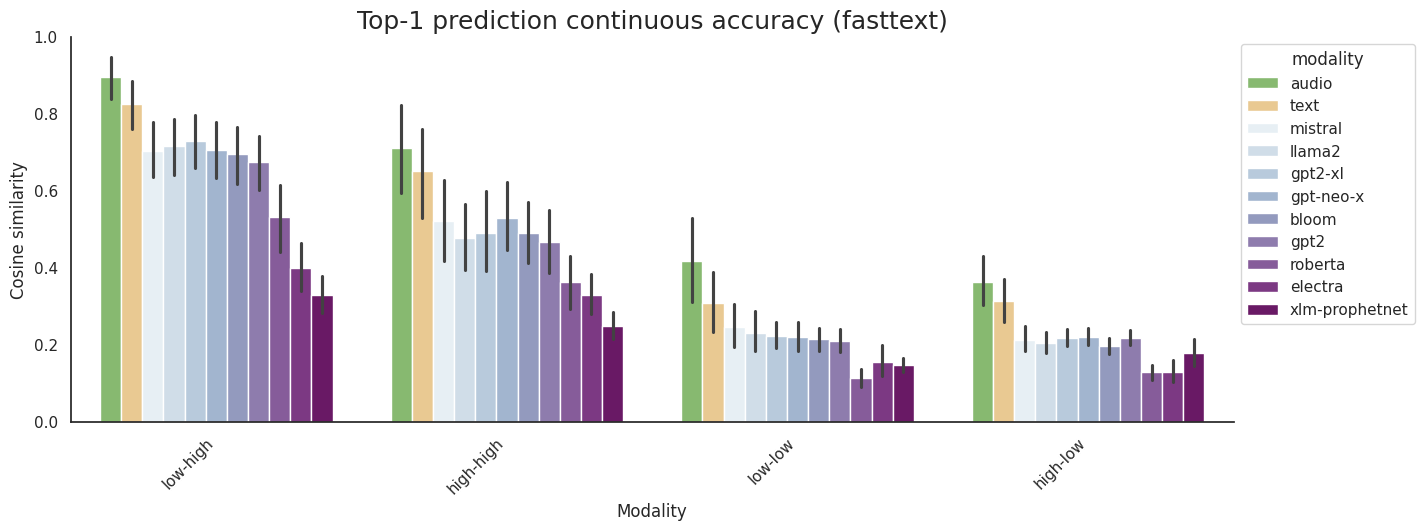

In [31]:
cmap = create_spoken_written_cmap(continuous=False)

fig, ax = plt.subplots(1,1, figsize=(15,5))

variable = f'{word_model_name}_avg_accuracy'

ax = sns.barplot(data=df_human_models, x='entropy_accuracy_group', y=variable, hue="modality",
                 palette=cmap, ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-1 prediction continuous accuracy ({word_model_name})')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

sns.despine()
# plt.savefig("prediction_accuracy.pdf", bbox_inches='tight', dpi=600)

In [146]:
for i, df in df_anova.groupby('entropy_accuracy_group'):
    print (i)
    df = df.dropna().reset_index(drop=True)
    model = ols('fasttext_avg_accuracy ~ modality', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=3)

    print (anova_table)
# human_model_combined = human_model_combined.dropna()

    hs_res=pairwise_tukeyhsd(df["fasttext_avg_accuracy"], df['modality'])
    print(hs_res)

high-high
              sum_sq     df           F        PR(>F)
Intercept  19.034199    1.0  215.261852  2.061615e-41
modality    8.687484   10.0    9.824862  3.255694e-15
Residual   48.986601  554.0         NaN           NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
    audio          bloom  -0.1422 0.3956 -0.3371  0.0527  False
    audio        electra  -0.3911    0.0 -0.5838 -0.1984   True
    audio      gpt-neo-x  -0.1623 0.2161 -0.3588  0.0341  False
    audio           gpt2  -0.1623 0.2213 -0.3596  0.0349  False
    audio        gpt2-xl  -0.0655 0.9949 -0.2728  0.1418  False
    audio         llama2  -0.2273 0.0172 -0.4334 -0.0212   True
    audio        mistral  -0.1409  0.537  -0.352  0.0703  False
    audio        roberta  -0.2451 0.0014 -0.4329 -0.0573   True
    audio           text  -0.0716 0.9898 -0.2789  0.1357  False
    au

### Plot 04 - Continuous accuracy over quadrants

In [112]:
def plot_quadrant_distributions(model_results, accuracy_type, percentile, indices=None):
    
    # get xmedian and ymedian --> needs to happen before otherwise plot is off
    x_median = np.nanmedian(model_results[accuracy_type])
    y_median = np.nanmedian(model_results['entropy'])
    
    xmin, xmax = model_results[accuracy_type].max(), model_results[accuracy_type].min()
    ymin, ymax = model_results['entropy'].max(), model_results['entropy'].min()
    
    # divide the data into quadrants based on percentile
    # we use a form of continuous accuracy and entropy
    df_divide = divide_nwp_dataframe(model_results, accuracy_type=accuracy_type, percentile=percentile, drop=False)

    if indices is not None:
        df_divide = df_divide.loc[indices]

    return df_divide
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    # axes = axes.flatten()
    
    ax = sns.scatterplot(data=df_divide, x=accuracy_type, y='entropy', hue='binary_accuracy', 
                     color='.6', palette="BuPu", alpha=0.75, ax=ax)
    
    # turn off top and right axes
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.vlines(x=x_median, ymin=ymin, ymax=ymax, linestyles='dashed', color='k')
    ax.hlines(y=y_median, xmin=xmin, xmax=xmax, linestyles='dashed', color='k')
    
    ax.title.set_text('Division of NWP candidates by median entropy/accuracy')
    
    return fig, ax

In [121]:
# FOR DIVIDING THE MODEL RESULTS INTO QUADRANTS
ACCURACY_TYPE = f'{word_model_name}_avg_accuracy'
ACCURACY_PERCENTILE = 45
WINDOW_SIZE = 25
TOP_N = 5

preproc_dir = os.path.join(BASE_DIR, 'stimuli', 'preprocessed')

# load our preprocessed file --> get the indices of the prediction words
df_preproc = pd.read_csv(os.path.join(preproc_dir, TASK, f'{TASK}_transcript-preprocessed.csv'))
nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]

# select based on model quadrants --> trim down to only the words of interest
model_results = load_model_results(models_dir, model_name='gpt2-xl', task=TASK, window_size=WINDOW_SIZE, top_n=TOP_N)
model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)
model_results = model_results.iloc[nwp_idxs]


In [122]:
modalities = ['audio', 'text']

human_model_accuracy_contrast = {}
models_only = df_human_models[~df_human_models['modality'].isin(['audio', 'text'])]
humans_only = df_human_models[df_human_models['modality'].isin(['audio', 'text'])]

audio, text = [df_human_models[df_human_models['modality'] == modality][ACCURACY_TYPE].to_numpy()[..., np.newaxis] for modality in modalities]

models_only = df_human_models[~df_human_models['modality'].isin(modalities)]
models_only = pd.pivot(models_only, index='word_index', columns='modality', values=ACCURACY_TYPE).to_numpy()

avg_model = np.nanmean(models_only, axis=1)[..., np.newaxis]

audio_v_model = audio - avg_model #np.nanmean(audio - models_only, axis=1)
text_v_model = text - avg_model # np.nanmean(text - models_only, axis=1)

In [123]:
from scipy.stats import zscore

def linear_norm(x, min, max):
    return (x - min) / (max - min)

In [124]:
# load our preprocessed file --> get the indices of the prediction words
df_selected = pd.read_csv(os.path.join(BASE_DIR, 'stimuli/preprocessed', TASK, f'{TASK}_transcript-selected.csv'))
selected_idxs = np.where(df_selected['NWP_Candidate'])[0]

# model_quadrants = get_model_word_quadrants('gpt2-xl', TASK, selected_idxs, accuracy_type=f'{word_model_name}_max_accuracy').reset_index(drop=True)
df_divide = plot_quadrant_distributions(model_results, ACCURACY_TYPE, ACCURACY_PERCENTILE, indices=selected_idxs)

min = -1 
max = 1

df_divide['audio>model'] = linear_norm(audio_v_model, min, max)
df_divide['text>model'] = linear_norm(text_v_model, min, max) #min_max_norm(np.nanmean(text - , axis=0)) 
df_divide['human>model'] = linear_norm((audio_v_model + text_v_model)/2, min, max) #, axis=0)) 
df_divide['audio>text'] = linear_norm(audio - text, min, max)

### Plot 03 - Continuous accuracy over LLM quadrants

Text(468.01587301587307, 0.5, 'Continuous Accuracy')

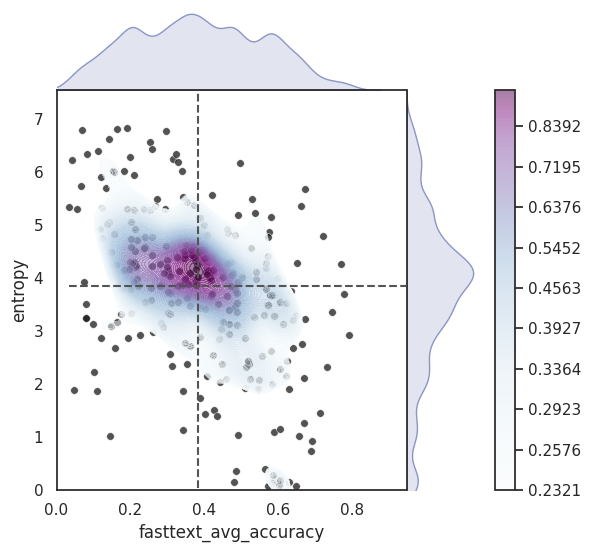

In [125]:
import seaborn as sns
from matplotlib import cm
sns.set_theme(style="white")

# df = sns.load_dataset("penguins")
# sns.set(style='white', rc={'figure.figsize':(6,5)})
cmap = cm.get_cmap('BuPu')

weight_type = 'human>model'
weights = df_divide[weight_type].to_numpy()
density_min = df_divide[weight_type].min()
density_max = df_divide[weight_type].max()

clip_x = (df_divide[ACCURACY_TYPE].min(), df_divide[ACCURACY_TYPE].max())
clip_y =  (df_divide["entropy"].min(), df_divide["entropy"].max())

g = sns.JointGrid(data=df_divide, x=ACCURACY_TYPE, y="entropy", space=0)


g.plot_joint(sns.scatterplot, color="k", alpha=0.75, s=30)


g.plot_joint(sns.kdeplot, weights=weights,
             bw_adjust=0.65, fill=True,
             thresh=0.65*weights.mean(), levels=100, cmap=cmap, alpha=0.5, cbar=True)

g.plot_marginals(sns.kdeplot, color=cmap(0.5), fill=True, bw_adjust=0.5) #, kde=True, alpha=1) #, bins=25)

# get xmedian and ymedian --> needs to happen before otherwise plot is off
x_median = np.nanmedian(model_results[ACCURACY_TYPE])
y_median = np.nanmedian(model_results['entropy'])

xmin, xmax = model_results[ACCURACY_TYPE].min(), model_results[ACCURACY_TYPE].max()
ymin, ymax = model_results['entropy'].min(), model_results['entropy'].max()


g.fig.axes[0].set_ylim(0, ymax)
g.fig.axes[0].set_xlim(0, xmax)

g.fig.axes[0].vlines(x=x_median, ymin=ymin, ymax=ymax, linestyles='dashed', color='.33')
g.fig.axes[0].hlines(y=y_median, xmin=xmin, xmax=xmax, linestyles='dashed', color='.33')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)


# # get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()

# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

# # get the current colorbar ticks
# cbar_ticks = g.fig.axes[-1].get_yticks()
# # # get the maximum value of the colorbar
# _, cbar_max = g.fig.axes[-1].get_ylim()

# g.fig.axes[-1]
# g.fig.axes[-1].set_yticks([i for i in range(1, 100, 10)])

# tick_locator = ticker.MaxNLocator(nbins=5)
# g.fig.axes[-1].locator = tick_locator
# g.fig.axes[-1].update_ticks()
# g.fig.axes[-1] = 

plt.ylabel('GPT2-XL Entropy')
plt.ylabel('Continuous Accuracy')

# plt.suptitle('Human accuracy improvement over model')

# cbar= plot_colorbar(vmin=difference_min, vmax=difference_max, vcenter=difference_center, nticks=6, cmap='mako', direction='vertical')
# g.fig.axes[-1].set_yticklabels([i for i in range(100)])

# # # change the labels (not the ticks themselves) to a percentage
# g.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 100:.1f} %' for t in cbar_ticks])

# plt.show()

# plt.savefig("entropy_accuracy_density.pdf", bbox_inches='tight', dpi=600)


In [468]:
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from matplotlib import ticker

def plot_colorbar(vmin, vmax, vcenter, nticks=5, direction='horizontal', cmap='RdBu_r', out_fn=None):
	
	fig = plt.figure()
	
	values = np.random.randn(10)
	
	divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
	psm = plt.pcolormesh([-values, values], norm=divnorm, cmap=cmap)
	plt.clf()
	
	# xloc, yloc, size x, size y
	if direction == 'horizontal':
		cbar_ax = fig.add_axes([0.5, 0, 0.6, 0.05])
	elif direction == 'vertical':
		cbar_ax = fig.add_axes([0.5, 0, 0.05, 0.6])
	
	fig.colorbar(psm, cax=cbar_ax, orientation=direction, ticks=ticker.MaxNLocator(nbins=nticks))
	return fig

### Plot 05 - Continuous accuracy line plot

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/asynchrony/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/scratch/ipykernel_6855/1228733465.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(1454.9247078741962, 0.5, 'Cosine similarity')

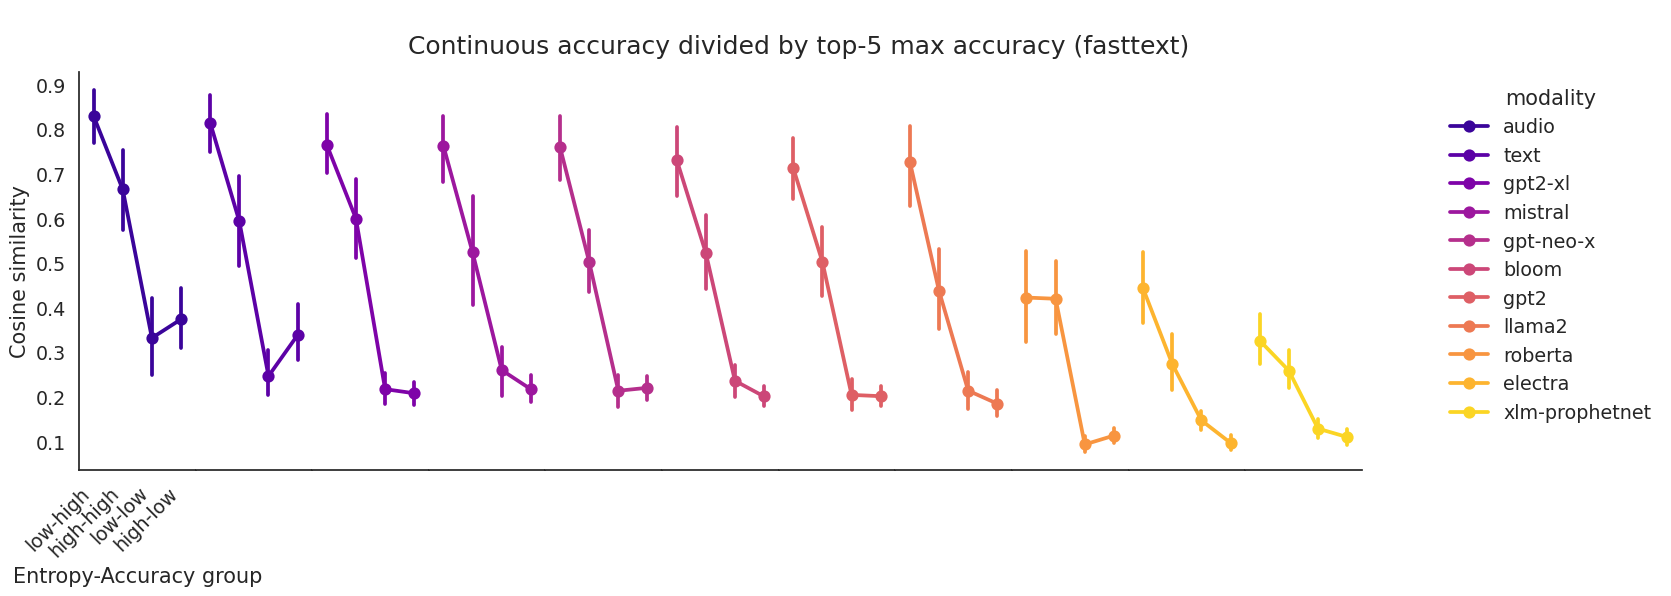

In [48]:
g = sns.catplot(
    data=human_model_combined, x="entropy_accuracy_group", y=f"{word_model_name}_avg_accuracy", col="modality",
    hue='modality', palette='plasma', kind="point", height=5, aspect=.25, 
    sharex=False, sharey=True, margin_titles=False, order=ordered_conditions, 
    col_order=ordered_modalities, hue_order=ordered_modalities
)

g.set_axis_labels("", "Cosine similarity")  # Optional: Set axis labels
g.set_titles(template="")
axes = g.axes.flat

# Despine all axes except the first
for i, ax in enumerate(axes):
    if i > 0:
        sns.despine(ax=ax, left=True)
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("Entropy-Accuracy group")

# Share x-axis among subplots
g.fig.subplots_adjust(wspace=0)

# Move the legend to the upper left on the first subplot
legend = g._legend
legend.set_bbox_to_anchor((0.9, 1.05))
legend.set_loc("upper left")

plt.suptitle(f'Continuous accuracy divided by top-5 max accuracy ({word_model_name})')
plt.ylabel('Cosine similarity')

## Archive - some set of random analyses

In [173]:
df_humans = human_model_combined[human_model_combined['modality'].isin(['audio', 'text'])]
df_models = human_model_combined[~human_model_combined['modality'].isin(['audio', 'text'])]

In [240]:
df_pred_sim = pd.DataFrame(columns=[
    'modality', 
    'model_name',
    'accuracy_corr',
    'avg_word_similarity'
])

accuracy_metric = 'fasttext_avg_accuracy'

all_word_similarity = []

for modality, df_modality in df_humans.groupby('modality'):
        
    df_modality = df_modality.reset_index(drop=True)
    
    # get human word vectors
    human_word_vectors = word_model[df_modality['top_pred']]
    
    for model_name, df_model in df_models.groupby('modality'):
        
        # get model word vectors
        model_word_vectors = word_model[df_model['top_pred']]
        
        # calculate average similarity
        similarity = 1 - cdist(human_word_vectors, model_word_vectors, metric='cosine')
        similarity = np.diag(similarity)
        
        # get similarity of humans to model words
        df = pd.DataFrame(similarity, columns=['word_similarity'])
        df['modality'] = modality
        df['model_name'] = model_name
        
        all_word_similarity.append(df)
        
        # now also correlate accuracy
        accuracy_corr = stats.pearsonr(df_modality[accuracy_metric], df_model[accuracy_metric])
        df_pred_sim.loc[len(df_pred_sim)] = {
            'modality': modality,
            'model_name': model_name,
            'accuracy_corr': accuracy_corr[0],
            'avg_word_similarity': np.nanmean(similarity)
        }
    

df_word_similarity = pd.concat(all_word_similarity).reset_index(drop=True)
human_pred_corr, _ = stats.pearsonr(df_humans[df_humans['modality'] == 'audio'][accuracy_metric], 
               df_humans[df_humans['modality'] == 'text'][accuracy_metric]
)

Find similarity of word vectors across modalities and models

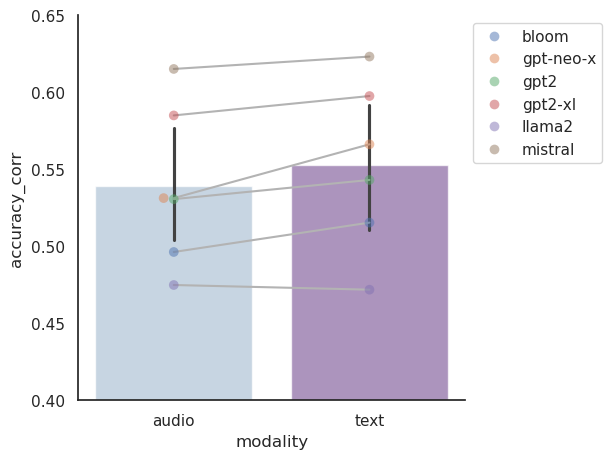

In [291]:
ax = sns.barplot(data=df_pred_sim, x='modality', y='accuracy_corr', palette='BuPu', alpha=0.7)
ax = sns.swarmplot(data=df_pred_sim, x='modality', y='accuracy_corr',hue='model_name',
                   s=7, color='k', alpha=0.5) #,palette=['red','green'])

ax = sns.lineplot(
    data=df_pred_sim, x="modality", y="accuracy_corr", units="model_name",
    color=".7", estimator=None
)

plt.ylim([0.4, 0.65])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [50]:
def load_all_model_results(task, selected_idxs):
    
    all_model_results = []
    
    for model_name in model_names:

        # load the results for the current model
        model_results = load_model_results(models_dir, model_name=model_name, task=task, top_n=1, window_size=100)
        model_results_trimmed = model_results.loc[selected_idxs, :]

        model_results_trimmed = model_results_trimmed.reset_index(names='word_index')
        model_results_trimmed['modality'] = model_name

        model_quadrants = get_model_word_quadrants(model_name, task, selected_idxs, accuracy_type=f'{word_model_name}_max_accuracy').reset_index(drop=True)
        entropy_accuracy_groups = model_quadrants['entropy_group'] + '-' +  model_quadrants['accuracy_group']

        model_results_trimmed['entropy_accuracy_group'] = entropy_accuracy_groups
        
        all_model_results.append((model_name, model_results_trimmed))
        
    return all_model_results

In [51]:
task='wheretheressmoke'

# load our preprocessed file --> get the indices of the prediction words
df_selected = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-selected.csv'))
selected_idxs = np.where(df_selected['NWP_Candidate'])[0]

all_model_results = load_all_model_results(task, selected_idxs)

df_human_results = collapse_human_results(df_results, word_model_info, top_n=1)

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:523: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:531: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:523: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a comp

In [ ]:
ax = sns.lineplot(x="modality", y="pred_sim_ratio", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

In [53]:
from scipy import stats

df_pred_sim = pd.DataFrame(columns=[
    'modality', 
    'model_name',
    'pred_sim_ratio',
    'predictability_corr'
])

for modality, df_human in df_human_results.groupby('modality'):
    
    df_human = df_human.reset_index(drop=True)
    
    for model_name, df_model in all_model_results:
        
        human_model_pred_sim = sum(df_human['top_pred'] == df_model['top_n_predictions'].apply(lambda x: x[0])) / len(df_human['top_pred'])
        
        predictability_corr = stats.pearsonr(df_human['binary_accuracy'], df_model['top_prob'])
        
        df_pred_sim.loc[len(df_pred_sim)] = {
            'modality': modality,
            'model_name': model_name,
            'pred_sim_ratio': human_model_pred_sim,
            'predictability_corr': predictability_corr[0]
        }

        
# then calculate the amount humans match humans across the conditions
df_text = df_human_results[df_human_results['modality'] == 'text'].reset_index(drop=True)
df_audio = df_human_results[df_human_results['modality'] == 'audio'].reset_index(drop=True)

human_condition_pred_sim = sum(df_text['top_pred'] == df_audio['top_pred']) / len(df_text['top_pred'])



How often does the top prediction of humans match the top prediction of models (regardless of accuracy)?

Text(0.5, 1.0, 'Human model prediction match')

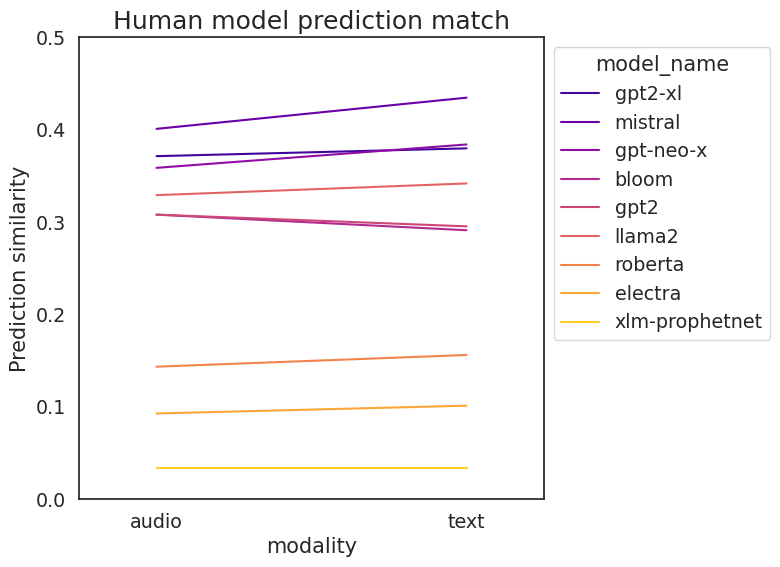

In [54]:
ax = sns.lineplot(x="modality", y="pred_sim_ratio", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

"We calculated the mean prediction performance for each word in the narrative, which we refer to as a ‘predictability score" -- Golstein 2022

Predictability per blank --> 
- Human predictability = number of participants getting the correct word
- Model predictability = model top prediction probability

In [137]:
_, results = zip(*all_model_results)

all_models_things = pd.concat(results)

In [142]:
all_models_things = all_models_things[['modality', 'word_index', 'top_prob', f'{word_model_name}_avg_accuracy', f'{word_model_name}_max_accuracy']]
all_models_things['binary_accuracy'] = all_models_things[f'{word_model_name}_avg_accuracy']


column_names = ['modality', 'word_index', 'binary_accuracy', f'{word_model_name}_avg_accuracy', f'{word_model_name}_max_accuracy']

model_human_things = pd.concat([df_human_results[column_names], all_models_things])



In [ ]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=model_human_things,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    height=5
)

In [147]:
model_human_things

,modality,word_index,binary_accuracy,fasttext_avg_accuracy,fasttext_max_accuracy,top_prob
0,audio,6,0.375000,1.000000,1.000000,NaN
1,audio,12,0.000000,0.155362,0.155362,NaN
2,audio,19,0.071429,0.185602,0.185602,NaN
3,audio,24,0.000000,0.179020,0.179020,NaN
4,audio,32,0.000000,0.138331,0.138331,NaN
...,...,...,...,...,...,...
189,xlm-prophetnet,1496,0.483367,0.483367,0.483367,0.067537
190,xlm-prophetnet,1507,0.381272,0.381272,0.381272,0.185992
191,xlm-prophetnet,1516,0.082457,0.082457,0.082457,0.135560
192,xlm-prophetnet,1530,0.337177,0.337177,0.337177,0.489594


In [134]:
df_human_results

,modality,word_index,binary_accuracy,top_pred,fasttext_avg_accuracy,fasttext_max_accuracy,fasttext_prediction_density,entropy_accuracy_group
0,audio,6,0.375000,college,1.000000,1.000000,NaN,low-high
1,audio,12,0.000000,boyfriend,0.155362,0.155362,NaN,high-low
2,audio,19,0.071429,road,0.185602,0.185602,NaN,high-low
3,audio,24,0.000000,interesting,0.179020,0.179020,NaN,high-low
4,audio,32,0.000000,good,0.138331,0.138331,NaN,high-low
...,...,...,...,...,...,...,...,...
383,text,1496,0.000000,need,0.523921,0.523921,NaN,high-high
384,text,1507,0.344828,know,1.000000,1.000000,NaN,low-high
385,text,1516,0.130435,life,0.336571,0.336571,NaN,low-low
386,text,1530,0.851852,job,1.000000,1.000000,NaN,low-high


Text(0.5, 1.0, 'Human model prediction match')

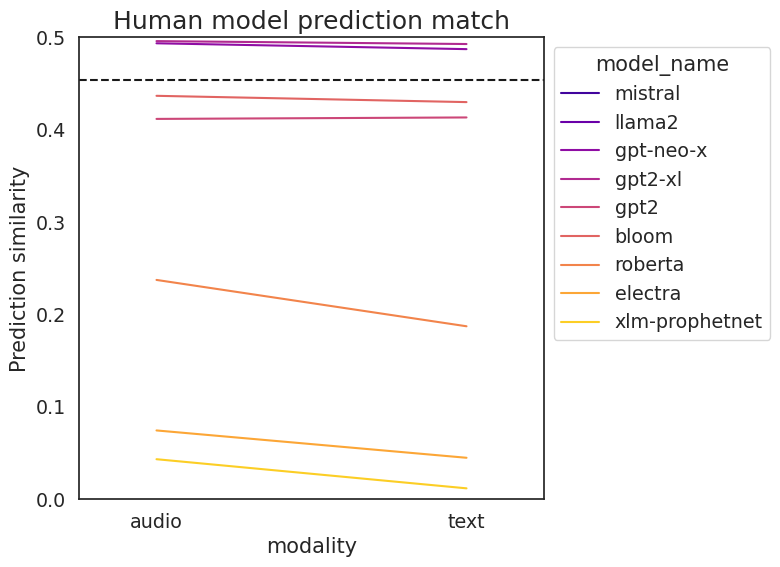

In [133]:
ax = sns.lineplot(x="modality", y="predictability_corr", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

Do humans and models evaluate predictability similarly (regardless of accuracy)?

## Semantic density of top 5 predictions

In [66]:
word_model_info

('glove', <gensim.models.keyedvectors.KeyedVectors at 0x2b16e8afd220>)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

ax = sns.barplot(data=human_model_combined, x='entropy_accuracy_group', y='glove_avg_accuracy', hue="modality",
                 palette='BuPu', ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Top 1 prediction continuous accuracy divided by quartile (word2vec)')
plt.ylabel('Cosine similarity')

In [ ]:
top_n = 5

for i, df in df_results.groupby(['modality', 'word_index']):
    
    df['response'] = df['response'].apply(strip_punctuation)
    
    human_probs, unique_words = get_human_probs(df['response'])

    # sort the probabilities --> then choose the top_n words
    sorted_probs = np.argsort(human_probs)[::-1]
    top_n_words = unique_words[sorted_probs[:top_n]]
    
#     if i[1] != 6:
    sys.exit(0)

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=human_model_top5, x='modality', y='word2vec_prediction_density', 
                 palette='BuPu', order=top1_ordered_accuracy) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

# ax = sns.stripplot(data=human_model_combined, x='modality', y='word2vec_continuous_accuracy',  hue='modality', palette='BuPu', size=5, 
#                    edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-5 prediction continuous accuracy')
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 0.4)

sns.despine()

In [ ]:
# go through the each modality word index
for (modality, response_index), df in df_results.groupby(['modality', 'word_index']):
    
    df['response'] = df['response'].apply(strip_punctuation)
    
    # use the same form as how we calculated language model metrics
    gt_pred_similarity, pred_distances = nlp.get_word_vector_metrics(word2vec, df['response'].unique().tolist(), df['ground_truth'].unique()[0])
    
    sys.exit(0)

In [ ]:
highschool_vec = np.mean([word2vec['high'], word2vec['school'] ], axis=0)

In [ ]:
word2vec.most_similar(positive=[highschool_vec], topn=10)

## Compare responses to models

In [112]:
import torch
from torch.nn import functional as F
from scipy.special import kl_div, rel_entr
from scipy import stats
from scipy.spatial import distance

def get_word_prob(tokenizer, word, logits):
    
    # use the tokenizer to find the index of each word, 
    idxs = tokenizer(word)['input_ids']
    probs = F.softmax(logits, dim=-1)
    word_prob = probs[:, idxs]
    
    return word_prob.squeeze().mean().item()

def load_logits(model_dir, model_name, task, window_size, word_index):
    '''
    Loads model data from directory
    '''

    model_dir = os.path.join(model_dir, task, model_name, f'window-size-{window_size}')
    logits_fns = natsorted(glob.glob(os.path.join(model_dir, 'logits', f'*{str(word_index).zfill(5)}*.pt')))
    
    assert (len(logits_fns) == 1)
    
    return torch.load(logits_fns[0])

def compare_human_model_distributions(tokenizer, word_model, human_responses, all_responses, model_logits, ground_truth):
    
    df = pd.DataFrame(columns=[
        'top_word_human', 
        'top_word_model',
        'top_word_model_adjusted',
        'prob_human',
        'prob_model',
        'prob_model_adjusted', 
        'prob_model_human_pred',
        'continuous_predictability_human',
        'predictability_human',
        'predictability_model',
        'kl_divergence',
        'relative_entropy',
        'wasserstein_dist',
        'jensenshannon_dist',
        'ks_stat'
    ])
    
    pre_filter = len(human_responses)
    human_responses = list(filter(None, human_responses))
    post_filter = len(human_responses)
    
    if pre_filter != post_filter:
        print (f'Removed {pre_filter - post_filter} empty responses')
    
    model_probs = F.softmax(model_logits, dim=-1).squeeze()
    prob_model = model_probs.max().item()
    top_word_model = tokenizer.decode(model_probs.argmax())
    
    ## get ground truth word prob
    gt_token = tokenizer.encode(ground_truth)
    gt_predictability_model = model_probs[gt_token].mean(0).item()
    human_predictability = sum(np.asarray(human_responses) == ground_truth) / len(human_responses)
    
    continuous_predictability = (1 - distance.cdist(word_model[ground_truth][np.newaxis], word_model[human_responses], metric='cosine')).mean()
    
    # get the probability distribution of the human responses --> also return the unique words
    human_probs, unique_words = get_human_probs(human_responses)
    prob_human = human_probs.max()
    
    # get the words indices in the overall array then add in the human probs
    word_idxs = [all_responses.index(word) for word in unique_words]    
    temp = np.zeros(len(all_responses))
    temp[word_idxs] = human_probs
    human_probs = temp
    
    # get probability of the words humans chose within the model distribution
    # then normalize to the number of samples
    model_adjusted_probs = np.asarray([get_word_prob(tokenizer, word, model_logits) for word in all_responses])
    model_adjusted_probs = model_adjusted_probs / model_adjusted_probs.sum()

    # select the probability of the top word that humans chose
    prob_model_adjusted = model_adjusted_probs[model_adjusted_probs.argmax()]
    prob_model_human_pred = model_adjusted_probs[human_probs.argmax()]

    # grab the human and model top words
    top_word_human = all_responses[human_probs.argmax()]
    top_word_model_adjusted = all_responses[model_adjusted_probs.argmax()]

    # now calculate kl divergence between the human and adjusted model distribution
    
    # measures how different P (human) is from Q (model) distribution
    
    #  KL divergence of P from Q is the expected excess surprise from 
    #  using Q as a model when the actual distribution is P
    kl_divergence = kl_div(human_probs, model_adjusted_probs)
    kl_divergence[np.isinf(kl_divergence)] = 0
    kl_divergence = kl_divergence.sum().item()
    
    relative_entropy = rel_entr(human_probs, model_adjusted_probs).sum().item()
    
    # wasserstein distance between adjusted probs
    wasserstein_dist = stats.wasserstein_distance(human_probs, model_adjusted_probs)
    
    jensenshannon_dist = distance.jensenshannon(human_probs, model_adjusted_probs)
    
    ks_stats = stats.kstest(human_probs, model_adjusted_probs)
    
    df.loc[len(df)] = {
        'top_word_human': top_word_human,
        'top_word_model': top_word_model,
        'top_word_model_adjusted': top_word_model,
        'prob_human': prob_human,
        'prob_model': prob_model,
        'prob_model_adjusted': prob_model_adjusted, 
        'prob_model_human_pred': prob_model_human_pred,
        'predictability_human': human_predictability,
        'predictability_model': gt_predictability_model,
        'continuous_predictability_human': continuous_predictability,
        'kl_divergence': kl_divergence,
        'relative_entropy': relative_entropy,
        'wasserstein_dist': wasserstein_dist,
        'jensenshannon_dist': jensenshannon_dist,
        'ks_stat': ks_stats[0]
    }
    
    return df
    

## Compare the model and human probability distributions

In [549]:
cmap = sns.color_palette("blend:#7C99B4,#DCAB6B", n_colors=2) #, as_cmap=True)
cmap

[(0.48627450980392156, 0.6, 0.7058823529411765),
 (0.8627450980392157, 0.6705882352941176, 0.4196078431372549)]

In [40]:
from scipy.stats import kendalltau

df_predictability = df_comparison.melt(id_vars=['log_odds_predictability_human', 'log_odds_predictability_model', 'modality', 'word_index'])

# drop infinite values
drop_idxs = df_predictability[np.isinf(df_predictability['log_odds_predictability_human'])]['word_index'].unique()
df_predictability = df_predictability[~df_predictability['word_index'].isin(drop_idxs)].reset_index(drop=True)

x_var = 'log_odds_predictability_human'
y_var = 'log_odds_predictability_model'
hue = 'modality'

fig = sns.lmplot(data=df_predictability, x=x_var, y=y_var, hue=hue, 
           palette=cmap, 
           # sharex=False,
           # sharey=False,
           # truncate=True,
           scatter_kws={"s": 10}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)

# for i, df_modality in df_predictability.groupby(['modality']):

#     r, pval = kendalltau(df_modality[x_var], df_modality[y_var])
#     print (i,  r, pval) from scipy.stats import pearsonr, spearmanr

sns.set(style='white', rc={'figure.figsize':(4,10)})

model_prob_type = 'prob_model'
human_prob_type = 'value'

# fig, axes = plt.subplots(1,2, sharey=True)
# axes = axes.flatten()

# df_comparison[model_prob_type] = np.log10(df_comparison[model_prob_type])

fig = sns.lmplot(data=df_predictability, x='value', y=model_prob_type, hue='modality', col='variable', 
           palette=cmap, 
           sharex=False,
           sharey=False,
           truncate=True,
           scatter_kws={"s": 10}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)

# plt.tight_layout()

axes = fig.axes
axes[0,0].set_xlim(0,1)
# plt.title('Similarity of prediction confidence (GPT2-XL)')
# plt.ylabel('Model - top prediction probability ')
# plt.xlabel('Human - top prediction probability ')
# plt.xlim([0,1])
plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.savefig("predictability.pdf", bbox_inches='tight', dpi=300)

for i, df_modality in df_predictability.groupby(['modality', 'variable']):

    r, pval = kendalltau(df_modality[human_prob_type], df_modality[model_prob_type])

#     print (r)
    print (i,  r, pval)

NameError: name 'df_comparison' is not defined

In [ ]:
from scipy.stats import pearsonr, spearmanr

model_prob_type = 'prob_model'

sns.lmplot(data=df_comparison, x="prob_human", y=model_prob_type, hue='modality', palette=cmap, scatter_kws={"s": 10}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)
plt.title('Similarity of prediction confidence (GPT2-XL)')
plt.ylabel('Model - top prediction probability ')
plt.xlabel('Human - top prediction probability ')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.savefig("probability.pdf", bbox_inches='tight', dpi=300)

for mod in df_comparison['modality'].unique():
    
    df_modality = df_comparison[df_comparison['modality'] == mod]

    r, pval = kendalltau(df_modality['prob_human'], df_modality[model_prob_type])
    
    print (mod, r, pval)

In [449]:
sns.color_palette('mako') 

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

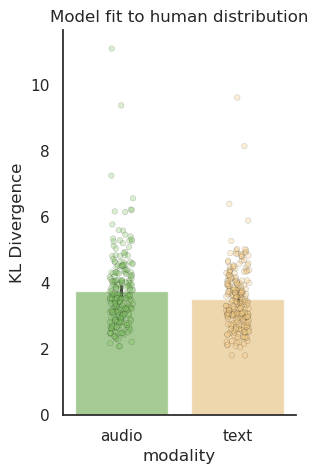

In [277]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

ax = sns.barplot(data=df_comparison, x='modality', y='kl_divergence', palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_comparison, x='modality', y='kl_divergence', palette=cmap, size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)
# plt.xlabel('Story')
plt.ylabel('KL Divergence')
plt.title('Model fit to human distribution')
# plt.ylim(0, 13)

sns.despine()

# plt.savefig("kl_divergence.pdf", bbox_inches='tight', dpi=300)

In [100]:
df_comparison

,top_word_human,top_word_model,top_word_model_adjusted,prob_human,prob_model,prob_model_adjusted,prob_model_human_pred,continuous_predictability_human,predictability_human,predictability_model,kl_divergence,relative_entropy,wasserstein_dist,jensenshannon_dist,ks_stat,modality,word_index,entropy_group,accuracy_group,ground_truth
0,grabbed,grabbed,grabbed,0.36,0.118946,0.028824,0.014377,0.172765,0.00,7.592915e-07,2.618122,2.618122,0.012803,0.721970,0.81,audio,4,high,low,secretly
1,hand,hand,hand,0.44,0.185340,0.020701,0.020701,0.359460,0.08,9.583791e-06,3.315492,3.315492,0.013916,0.775174,0.85,audio,11,high,low,foot
2,shoes,idea,idea,0.24,0.529246,0.060510,0.000725,0.331627,0.24,2.227037e-07,4.498756,4.498756,0.010349,0.775418,0.86,audio,30,low,low,shoes
3,cold,bare,bare,0.30,0.204284,0.043804,0.006650,0.320490,0.02,4.966940e-07,3.372161,3.372161,0.012904,0.744236,0.84,audio,34,high,low,crying
4,money,idea,idea,0.30,0.197104,0.061299,0.004056,0.302560,0.00,2.216063e-06,3.586582,3.586582,0.010292,0.753663,0.81,audio,38,high,low,wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,money,money,money,0.44,0.633084,0.016963,0.016963,0.452648,0.28,1.228589e-06,3.439201,3.439201,0.016268,0.777844,0.89,text,1738,low,low,gas
470,baby,car,car,0.20,0.219141,0.144238,0.000515,0.439666,0.20,2.906705e-08,3.767868,3.767868,0.008042,0.734661,0.80,text,1745,high,low,baby
471,the,the,the,0.42,0.278929,0.041033,0.030362,0.419362,0.16,3.005399e-08,3.737690,3.737690,0.013322,0.746239,0.88,text,1758,low,low,seven
472,know,you,you,0.26,0.262178,0.058485,0.011449,0.149262,0.02,1.304133e-07,3.234653,3.234653,0.008433,0.745592,0.79,text,1783,high,low,held


In [111]:
items, dfs = zip(*df_comparison.groupby('modality'))

stats.ttest_ind(dfs[0]['wasserstein_dist'], dfs[1]['wasserstein_dist'])

TtestResult(statistic=0.8209419606894662, pvalue=0.4120937560074627, df=472.0)

## Compare humans audio to humans text